In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from glob import glob
from natsort import natsorted
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import sys
import os
import logging
from pathlib import Path

# Set up file paths
file_path = str(Path().absolute())
project_path = str(Path().absolute().parent.parent)
exp_name = file_path.split('/')[-1]

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logging.info(f"Current file directory: {file_path}")
logging.info(f"Current project directory: {project_path}")

os.chdir(project_path)
sys.path.append(project_path)

# Import custom modules
from src.utils import split_intervals

# Read raw data
exp = 'w12_18.spont'
input_dir = f"{project_path}/data/processed/{exp}"

files = os.listdir(input_dir)

for file in files:
    if file.endswith('.npy'):
        if file == 'Probe1_lfps_spont.npy':
            ecog_data = np.load(input_dir + '/' + file, allow_pickle=True)
        if file == 'times.npy':
            times = np.load(input_dir + '/' + file, allow_pickle=True)

# Read upstate event times
upstates = np.load(f"{input_dir}/event_times.npy", allow_pickle=True)

# Get downstates as intervals between upstates
downstates = []
for i in range(len(upstates) - 1):
    downstates.append([upstates[i][1], upstates[i + 1][0]])

2023-08-06 23:01:20,597 - INFO - Current file directory: /Users/septentrionalem/Desktop/study/thesis_2023_travelling_waves/exp/travelling-waves-detection
2023-08-06 23:01:20,597 - INFO - Current project directory: /Users/septentrionalem/Desktop/study/thesis_2023_travelling_waves


In [2]:
# read ibw files till 64 channel
data = ecog_data
# organize data according to channel map
channel_map = np.array([[49,50,51,52,59,58,57,56,55,54,53],
                        [60,61,62,63,54,43,44,45,46,47,65],
                        [42,41,40,39,38,33,34,35,36,37,65],
                        [26,25,24,23,22,17,18,19,20,21,65],
                        [12,13,14,15,16,27,28,29,30,31,65],
                        [1,2,3,4,11,10,9,8,7,6,5]])
data = np.array(data)

# Perform a common reference removal on the data
data = data - np.mean(data, axis=0)

In [3]:
#! If you want to show only beta band 
from neurodsp.filt import filter_signal

# Filter data in alpha band
fs = 1000
f_range = (7, 13)
for d in range(data.shape[0]):
    data[d] = filter_signal(data[d], fs, 'bandpass', f_range, remove_edges=False)

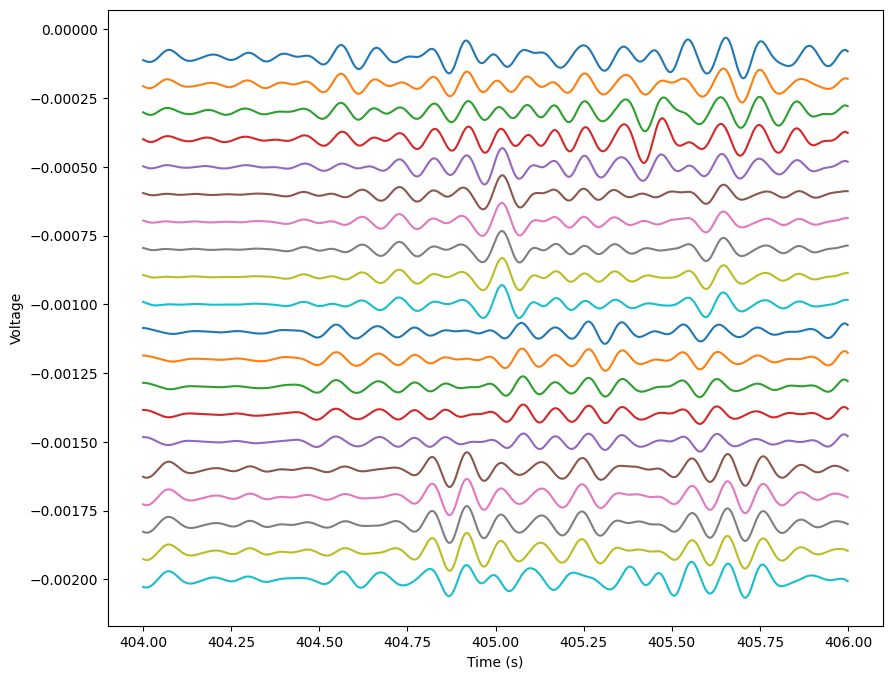

In [4]:
# plot all time series
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
for i in range(1, 64):
    if i > 20:
        continue
    ax.plot(times[404000:406000], data[i, 404000:406000] - i*0.0001)

ax.set_ylabel('Voltage')
ax.set_xlabel('Time (s)')
plt.show()

(1565508,)


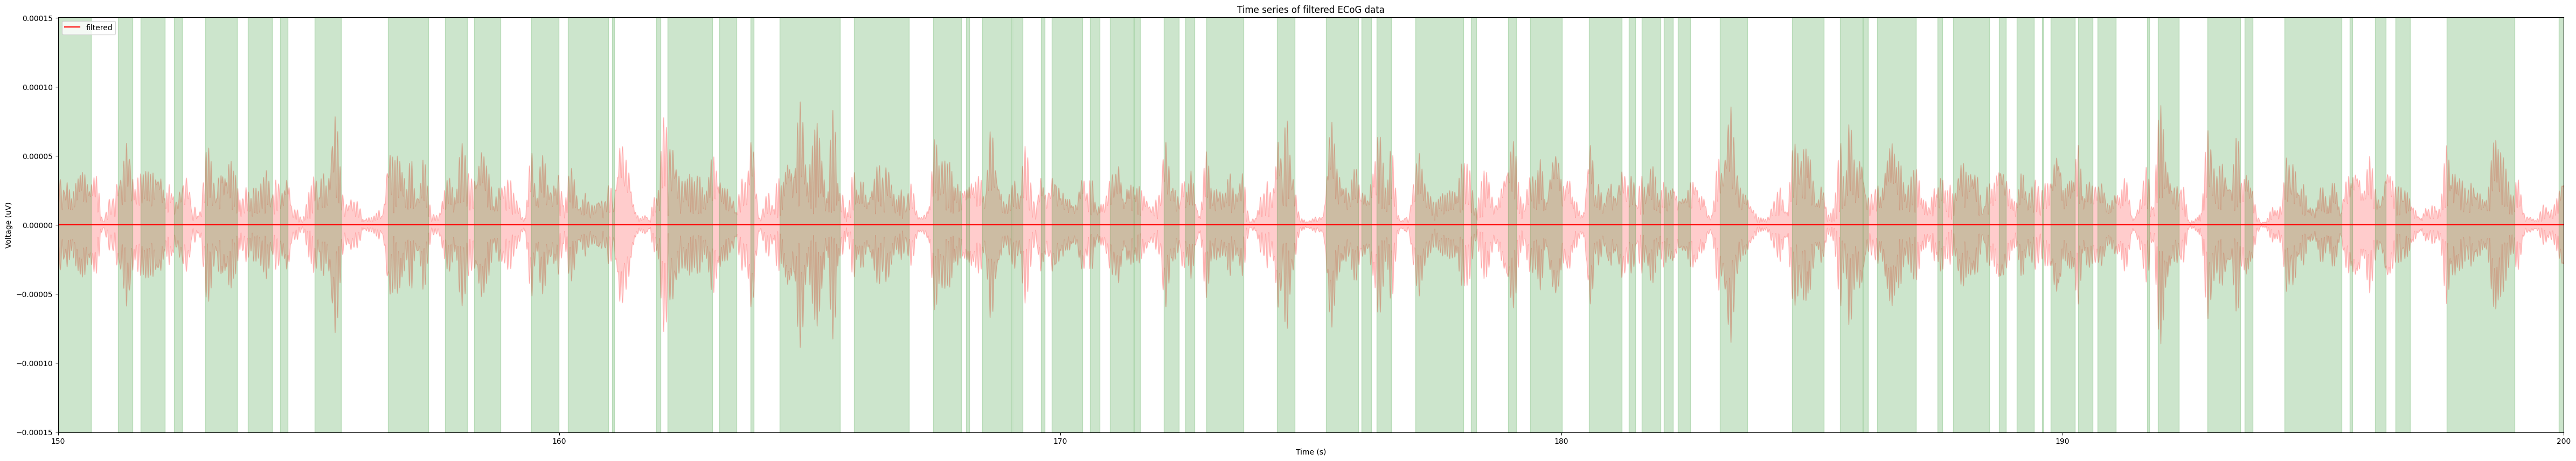

In [5]:
sig_filt_mean = np.mean(data, axis=0)

print(sig_filt_mean.shape)
fig =  plt.figure(figsize=(60, 10))
plt.plot(times, sig_filt_mean, label='filtered', color='red')
plt.fill_between(times, sig_filt_mean - np.std(data, axis=0), sig_filt_mean + np.std(data, axis=0), color='red', alpha=0.2)
for i in range(len(upstates)):
    plt.axvspan(upstates[i][0], upstates[i][1], alpha=0.2, color='green')
# plt.axhline(y=threshold_value, color='black', linestyle='--')
plt.legend()
plt.xlim((150, 200))
plt.xlabel('Time (s)')
plt.ylabel('Voltage (uV)')
plt.title('Time series of filtered ECoG data')
fig.savefig(f'filtered_data_example_with_upstates.png')

In [6]:
# data = data[:, 404000:406000]
# times = times[404000:406000]
# print(data.shape, times.shape)

In [7]:
# normalize data to 0-1
data = (data - data.min()) / (data.max() - data.min())

# add 65th channel with zeros
empty = np.zeros((data.shape[1]))
data = np.vstack((data, empty))
data.shape

(65, 1565508)

In [8]:
im = np.zeros((channel_map.shape[0], channel_map.shape[1], len(times)))

# Get the positions of the channels in the channel map
x, y = np.where(channel_map > 0)

# Calculate the values for the image
values = data[channel_map[x, y] - 1]
im[x, y, :] = values

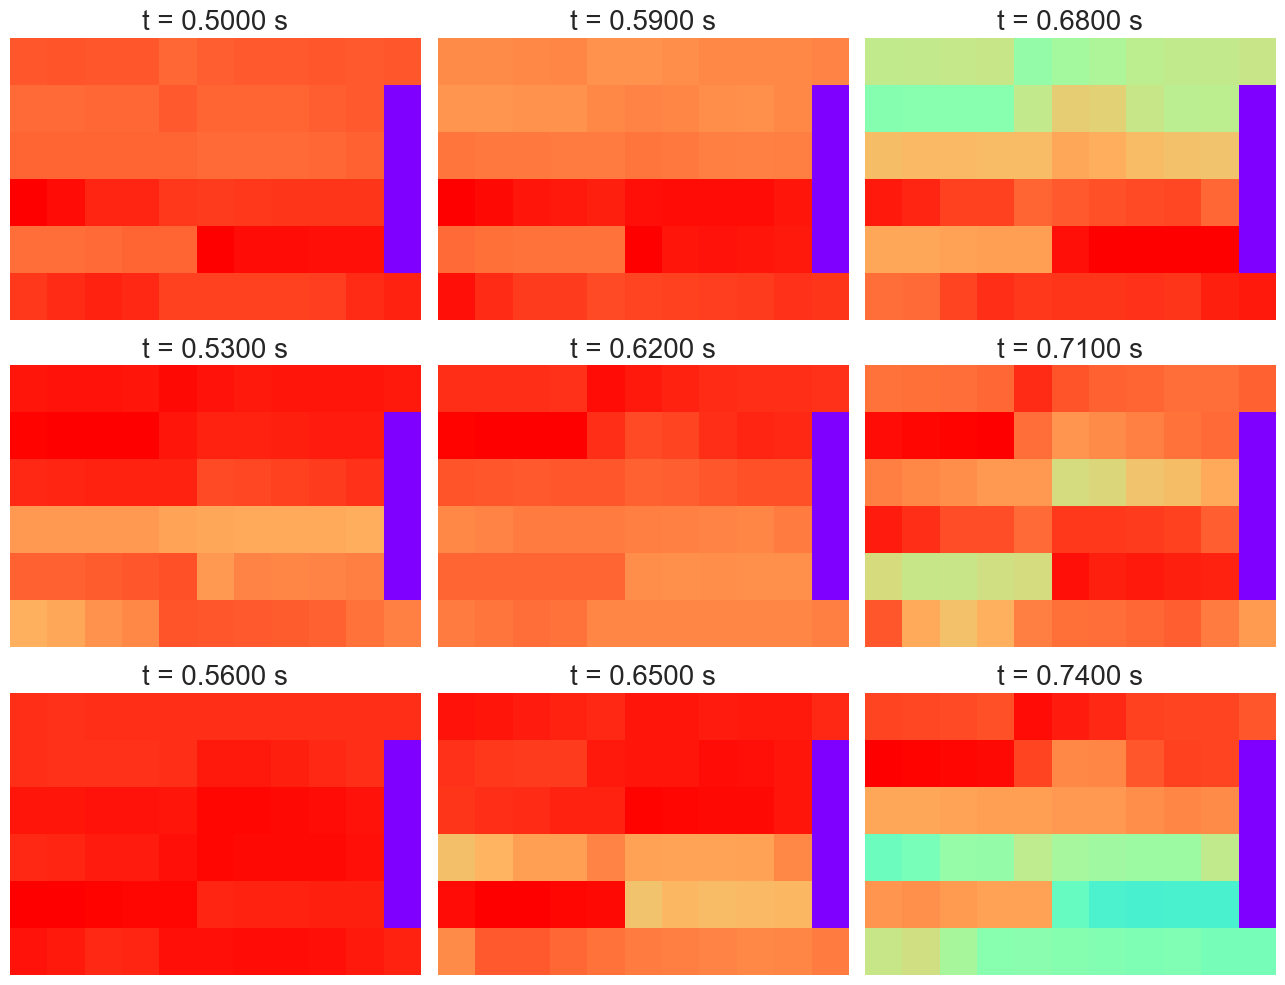

In [11]:
from matplotlib.gridspec import GridSpec
import seaborn as sns

# #Set plotting style
sns.set_context('paper', font_scale=1.2, rc={'lines.linewidth': 2})
sns.set_palette('colorblind')
sns.set_style('white')

# Set color palette and style
color_palette = ['tab:red', 'tab:blue', 'tab:green', 'tab:orange', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
sns.set_palette(color_palette)


# Set GridSpec for the figure
fig = plt.figure(figsize=(13, 10))
gs = GridSpec(3, 3, figure=fig)

ax1 = fig.add_subplot(gs[0, 0]) # travelling wave i = 0
ax2 = fig.add_subplot(gs[1, 0]) # travelling wave i = 2
ax3 = fig.add_subplot(gs[2, 0]) # travelling wave i = 4
ax4 = fig.add_subplot(gs[0, 1]) # travelling wave i = 6
ax5 = fig.add_subplot(gs[1, 1]) # travelling wave i = 8
ax6 = fig.add_subplot(gs[2, 1]) # travelling wave i = 10
ax7 = fig.add_subplot(gs[0, 2]) # travelling wave i = 12
ax8 = fig.add_subplot(gs[1, 2]) # travelling wave i = 14
ax9 = fig.add_subplot(gs[2, 2]) # travelling wave i = 16

axs = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9]

for j, i in enumerate(range(500, 1500, 30)):
    if j > len(axs) - 1:
        break
    axs[j].axis('off')
    axs[j].imshow(im[:, :, i], cmap='rainbow', aspect='auto')
    # add title with time in format up to 4 decimal places
    axs[j].set_title(f't = {i / 1000:.4f} s', fontsize=20)

plt.tight_layout()
plt.show()

2023-08-06 22:34:59,674 - WARNING - MovieWriter imagemagick unavailable; using Pillow instead.
2023-08-06 22:34:59,676 - INFO - Animation.save using <class 'matplotlib.animation.PillowWriter'>


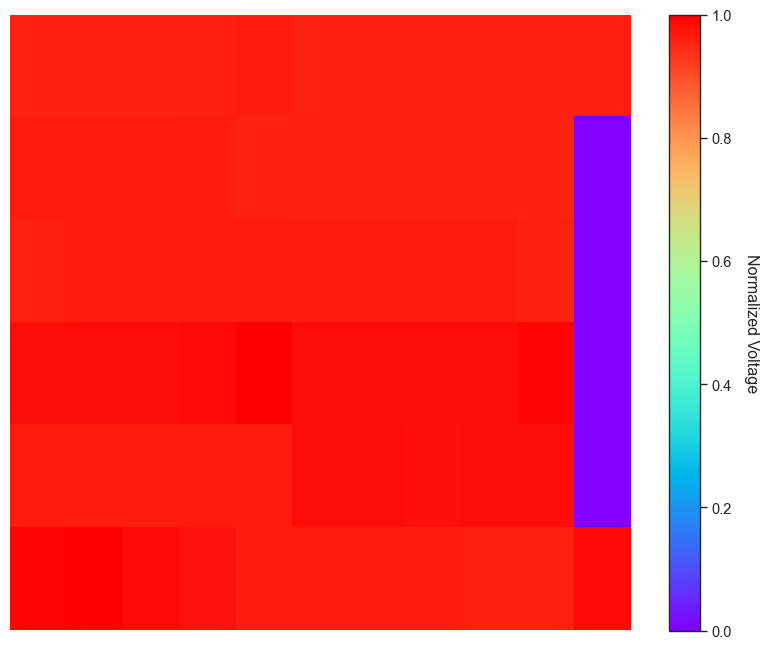

In [53]:
# def animate function
# set figure with 2 axes
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
n_frames = 1000
# set color bar
# create a colorbar
cbar = fig.colorbar(plt.cm.ScalarMappable(cmap='rainbow'), ax=ax)
# set label for color bar
cbar.set_label('Normalized Voltage', rotation=270, labelpad=20)
def animate(i):
    # clear the axes
    ax.clear()
    ax.imshow(im[:, :, i], cmap='rainbow', aspect='auto')
    ax.axis('off')
    
# set frame by frame as animation
ani = animation.FuncAnimation(plt.gcf(), animate, frames=n_frames)
# save animation
ani.save('travelling_waves_crr.gif', writer='imagemagick', fps=10)